<a href="https://colab.research.google.com/github/chitingchiang/style_transfer/blob/master/style_transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam

import matplotlib.pyplot as pt
import matplotlib.style
matplotlib.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 8)

from torchvision.models import vgg16
from torchvision.models import vgg19

from skimage.io import imread
from skimage.transform import resize

import copy
import time

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/style_transfer

In [0]:
def load_image(img_path):
    img = imread(img_path)
    w, h, c = img.shape
    max_dim = 512
    w_new = np.int32(w/np.max([w, h])*max_dim)
    h_new = np.int32(h/np.max([w, h])*max_dim)
    img = np.float32(np.expand_dims(resize(img, (w_new, h_new)), axis=0))
    return img

In [0]:
content_img = load_image('cola.jpg')
style_img = load_image('starry_night.jpg')

(1, 512, 383, 3)


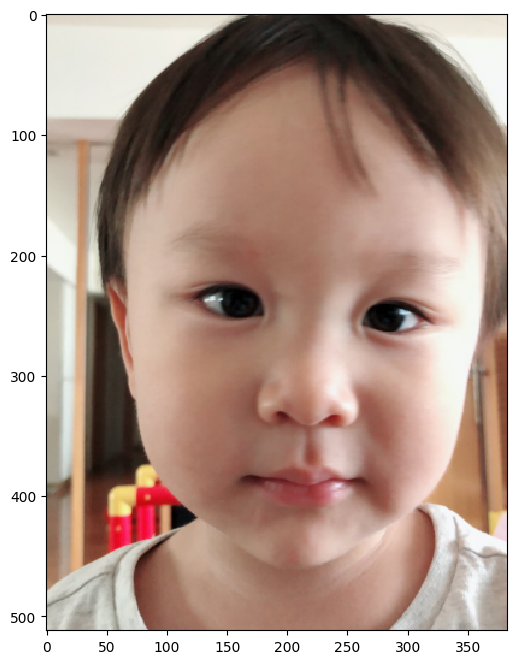

In [0]:
print(content_img.shape)
pt.imshow(content_img[0])

(1, 405, 512, 3)


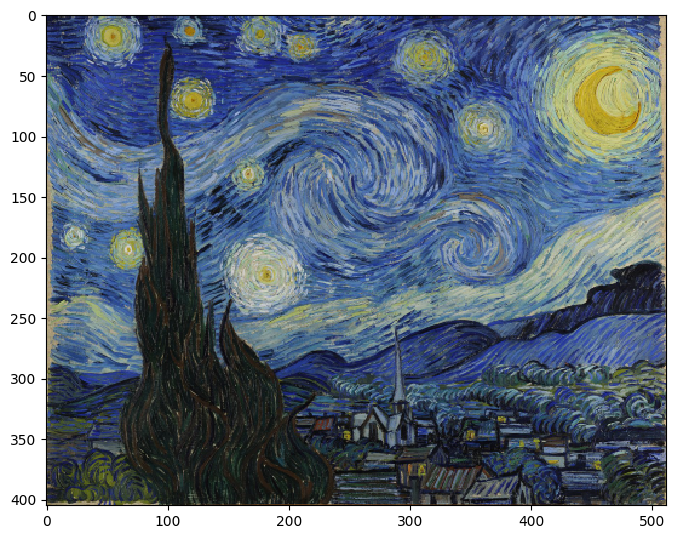

In [0]:
print(style_img.shape)
pt.imshow(style_img[0])

In [0]:
vgg_img_avg = np.array([0.485, 0.456, 0.406])
vgg_img_std = np.array([0.229, 0.224, 0.225])

def process_image(img):
    img = (img-vgg_img_avg)/vgg_img_std
    img = np.float32(np.moveaxis(img, -1, 1))
    return img
  
def deprocess_image(img):
    img = np.float32(np.moveaxis(img, 1, -1))
    img = img*vgg_img_std+vgg_img_avg
    return img

In [0]:
content_img = process_image(content_img)
style_img = process_image(style_img)

content_img = torch.from_numpy(content_img).to(device)
style_img = torch.from_numpy(style_img).to(device)

In [0]:
class ExtractFeatures(torch.nn.Module):
    def __init__(self, model):
        super(ExtractFeatures, self).__init__()
        features = list(model.features.to(device))
        self.features = nn.ModuleList(features).eval() 
        
    def forward(self, img, layer_list):
        results = []
        for i_layer, model in enumerate(self.features):
            img = model(img)
            if i_layer in layer_list:
                results.append(img)
        return results

In [0]:
def calculate_gram_matrix(x):
    x = x.view((x.size()[1], -1))
    gram = torch.mm(x, x.t())/x.size()[1]
    return gram

In [0]:
def generate_target_image(content_img, style_img, model,
                          content_layer_list, style_layer_list,
                          content_weight=1e3, style_weight=1e-2, variation_weight=0,
                          n_iteration=1000, learning_rate=5):
    
    target_img = content_img.clone().detach().requires_grad_(True)
    optimizer = Adam([target_img], lr=learning_rate, betas=(0.99, 0.999), eps=1e-1)
    
    n_content_layer = len(content_layer_list)
    n_style_layer = len(style_layer_list)
    
    extract_features = ExtractFeatures(model)
    
    content_features = extract_features(content_img, content_layer_list)
    style_features = extract_features(style_img, style_layer_list)
    
    for i_iteration in range(n_iteration):

        target_content_features = extract_features(target_img, content_layer_list)
        content_loss = 0
        for i in range(n_content_layer):
            content_loss += torch.mean((content_features[i]-target_content_features[i])**2)
        content_loss = content_loss*content_weight/n_content_layer
        
        target_style_features = extract_features(target_img, style_layer_list)
        style_loss = 0
        for i in range(n_style_layer):
            style_gram = calculate_gram_matrix(style_features[i])
            target_gram = calculate_gram_matrix(target_style_features[i])
            style_loss += torch.mean((style_gram-target_gram)**2)
        style_loss = style_loss*style_weight/n_style_layer
        
        variation_loss1 = (target_img[:, :, :-1, :-1]-target_img[:, :, 1:, :-1])**2
        variation_loss2 = (target_img[:, :, :-1, :-1]-target_img[:, :, :-1, 1:])**2
        variation_loss = torch.mean(variation_loss1+variation_loss2)*variation_weight
        
        loss = content_loss+style_loss+variation_loss
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        print('iteration %d: content_loss=%.4e, style_loss=%.4e, variation_loss=%.4e, loss=%.4e'\
              %(i_iteration, content_loss, style_loss, variation_loss, loss))
        
    return target_img

iteration 0: content_loss=0.0000e+00, style_loss=4.5731e+02, variation_loss=2.4585e-01, loss=4.5756e+02
iteration 1: content_loss=2.1719e-01, style_loss=3.8778e+02, variation_loss=2.6188e-01, loss=3.8826e+02
iteration 2: content_loss=7.0714e-01, style_loss=3.1300e+02, variation_loss=2.9914e-01, loss=3.1401e+02
iteration 3: content_loss=1.2681e+00, style_loss=2.4310e+02, variation_loss=3.5780e-01, loss=2.4473e+02
iteration 4: content_loss=1.9410e+00, style_loss=1.9071e+02, variation_loss=4.4012e-01, loss=1.9309e+02
iteration 5: content_loss=2.6382e+00, style_loss=1.5251e+02, variation_loss=5.4346e-01, loss=1.5569e+02
iteration 6: content_loss=3.3347e+00, style_loss=1.2370e+02, variation_loss=6.6493e-01, loss=1.2770e+02
iteration 7: content_loss=4.0326e+00, style_loss=1.0580e+02, variation_loss=8.0182e-01, loss=1.1063e+02
iteration 8: content_loss=4.7171e+00, style_loss=9.7095e+01, variation_loss=9.5043e-01, loss=1.0276e+02
iteration 9: content_loss=5.3610e+00, style_loss=9.5249e+01, var

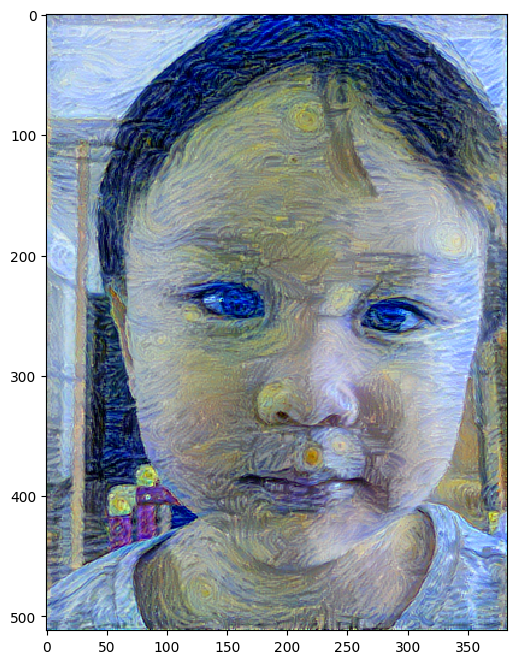

In [0]:
content_layer_list = [8]
style_layer_list = [3, 8, 15, 22, 29]

target_img = generate_target_image(content_img, style_img, vgg16(pretrained=True),
                                   content_layer_list, style_layer_list,
                                   content_weight=1, style_weight=3e2, variation_weight=1e1,
                                   n_iteration=1000, learning_rate=5)

target_img = target_img.cpu().detach().numpy()
target_img = deprocess_image(target_img).clip(0, 1)
pt.imshow(target_img[0])